In [1]:
%matplotlib inline

In [6]:
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import riboutils.ribo_utils as ribo_utils
import misc.bio as bio

In [3]:
def get_orf_label_counts(counts, orf_label):
    orf_types = ribo_utils.orf_type_labels_mapping[orf_label]
    orf_label_counts = np.sum(counts[orf_types])
    
    if np.isnan(orf_label_counts):
        orf_label_counts = 0
    return orf_label_counts

In [19]:
#orfs_file = "/prj/shirin-riboseq/RPF/orf-predictions/rat.serum.nrvm-unique.length-21-22-23-24-25-26-27-28-29.offset-12-12-12-12-9-9-12-12-12.predicted-orfs.bed.gz"
#image_file = "/prj/shirin-riboseq/RPF/orf-predictions/plots/rat.serum.nrvm-unique.length-21-22-23-24-25-26-27-28-29.offset-12-12-12-12-9-9-12-12-12.predicted-orfs.orf-types.pdf"

orfs_file = "/prj/shirin-riboseq/RPF/orf-predictions/rat.no-serum.nrvm-unique.length-26-29.offset-12-12.predicted-orfs.bed.gz"
image_file = "/prj/shirin-riboseq/RPF/orf-predictions/plots/rat.no-serum.nrvm-unique.length-26-29.offset-12-12.predicted-orfs.orf-types.pdf"
use_groups = True
title = "rat, no serum"

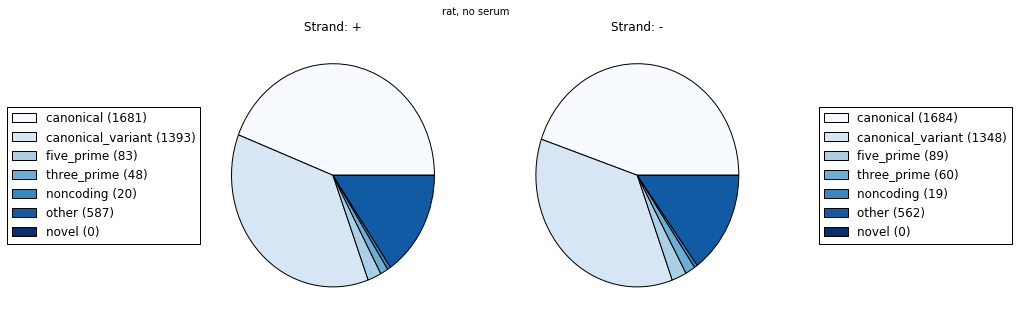

In [20]:

orfs = bio.read_bed(orfs_file)

strands = ['+', '-']
fracs = []
labels = []
for strand in ['+', '-']:
    m_strand = orfs['strand'] == strand
    orf_type_groups = orfs[m_strand].groupby('orf_type')
    counts = orf_type_groups.size()

    if use_groups:
        lab = ribo_utils.orf_type_labels
        fr = [get_orf_label_counts(counts, l) for l in lab]
    else:
        fr = counts.values
        lab = np.array(counts.index)

    lab = ["{} ({})".format(l,f) for l,f in zip(lab, fr)]

    fracs.append(fr)
    labels.append(lab)

fig, axes = plt.subplots(ncols=2, figsize=(10,5))

cmap = plt.cm.Blues
colors = cmap(np.linspace(0., 1., len(labels[0])))

# forward strand ORFs

extra_artists = []
if sum(fracs[0]) > 0:
    patches, texts = axes[0].pie(fracs[0], colors=colors)
    lgd = axes[0].legend(patches, labels[0], loc="center right", bbox_to_anchor=(0,0.5))
    axes[0].set_title("Strand: {}".format(strands[0]))

    extra_artists.append(lgd)
else:
    title = "Strand: {}. No ORFs".format(strands[0])
    axes[0].set_title(title)
    axes[0].set_axis_off()

# reverse strand ORFs
if sum(fracs[1]) > 0:
    patches, texts = axes[1].pie(fracs[1], colors=colors)
    lgd = axes[1].legend(patches, labels[1], loc="center right", bbox_to_anchor=(2.0,0.5))
    axes[1].set_title("Strand: {}".format(strands[1]))
    extra_artists.append(lgd)
else:
    title = "Strand: {}. No ORFs".format(strands[1])
    axes[1].set_title(title)
    axes[1].set_axis_off()

if len(title) > 0:
    sup = fig.suptitle(title)
    extra_artists.append(sup)

if image_file is not None:
    fig.savefig(image_file, bbox_extra_artists=extra_artists, bbox_inches='tight')


In [3]:
#orfs_file = "/data/projects/departments/Christoph_Dieterich/riboseq/caenorhabditis_elegans/WBcel235_79/transcript-index/WBcel235.79.genomic-orfs.aug-only.bed.gz"
#orfs_file = "/data/projects/departments/Christoph_Dieterich/riboseq/homo_sapiens/gencode.v19/transcript-index/gencode-v19.genomic-orfs.aug-only.bed.gz"
#orfs_file = "/data/projects/departments/Christoph_Dieterich/riboseq/mus_musculus/GRCm38_79/transcript-index/GRCm38_79.genomic-orfs.aug-only.bed.gz"
#orfs_file = "/home/bmalone/data//homo_sapiens/GRCh38_79/transcript-index/GRCh38_79.genomic-orfs.aug-only.bed.gz"
#orfs_file = "/genomes/caenorhabditis_elegans/WBcel235.79.plus-de-novo/transcript-index/WBcel235.79.plus-de-novo.genomic-orfs.atg-only.bed.gz"
#orfs_file = "/prj/grosshans-riboseq/RPF/orf-predictions/early-samples-unique.smooth.predicted-orfs.bed.gz"
orfs_file = "/prj/shirin-riboseq/RPF/orf-predictions/rat.no-serum.nrvm-unique.length-26-29.offset-12-12.predicted-orfs.bed.gz"

orfs = pd.read_csv(orfs_file, sep='\t')
orfs.columns = [c.replace("#", "") for c in orfs.columns]

orf_type_groups = orfs.groupby('orf_type')
counts_pd = orf_type_groups.size()

counts = collections.defaultdict(int)
counts.update(counts_pd.to_dict())

canonical_count = counts['canonical'] + counts['canonical_truncated'] + counts['canonical_extended']
five_prime_count = counts['five_prime'] + counts['five_prime_overlap']
three_prime_count = counts['three_prime'] + counts['three_prime_overlap']
within_count = counts['within']
noncoding_count = counts['noncoding']
suspect_overlap_count = counts['suspect_overlap'] + counts['novel_suspect_overlap']

novel_count = counts['novel']

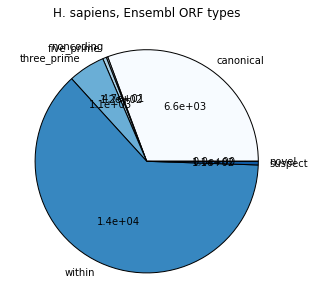

In [19]:
image = "homo-sapiens-ensembl-orf-types.eps"
title = "H. sapiens, Ensembl ORF types"

labels = ['canonical', 'noncoding', 'five_prime', 'three_prime', 'within', 'suspect', 'novel']
fracs = [canonical_count, noncoding_count, five_prime_count, three_prime_count, within_count, suspect_overlap_count, novel_count]

#labels = ['canonical', "", 'five_prime', 'three_prime', 'within', 'suspect']
#fracs = [canonical_count, 0, five_prime_count, three_prime_count, within_count, suspect_overlap_count]


fig, ax = plt.subplots(figsize=(5,5))

cmap = plt.cm.Blues
colors = cmap(np.linspace(0., 1., len(labels)))

patches, texts, autotexts = ax.pie(fracs, labels=labels, colors=colors, autopct="%.1f%%")

for autotext, count in zip(autotexts, fracs):
    #autotext.set_text(u"%s (%d)" % (autotext.get_text(), counts))
    autotext.set_text("{:.1e}".format(count))

ax.set_title(title)

#fig.tight_layout()
if image is not None:
    fig.savefig(image)

In [9]:
counts

orf_type
canonical                 26147
canonical_extended        16769
canonical_truncated      208670
five_prime                 4978
five_prime_overlap         3024
noncoding                 40015
novel                     24331
novel_suspect_overlap      7193
suspect_overlap            1581
three_prime               19144
three_prime_overlap       17105
within                   339102
dtype: int64

In [29]:
def get_orf_label_counts(counts, orf_label):
    orf_types = ribo_utils.orf_type_labels_mapping[orf_label]
    orf_label_counts = np.sum(counts[orf_types])
    
    if np.isnan(orf_label_counts):
        orf_label_counts = 0
    return orf_label_counts

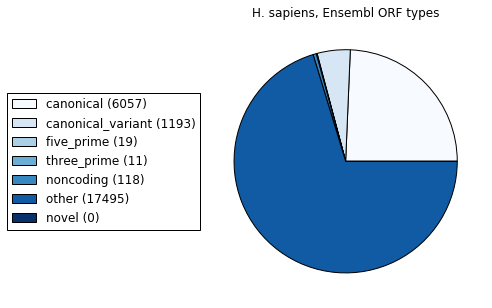

In [30]:
image = None
title = "H. sapiens, Ensembl ORF types"

fracs = counts_pd.values
labels = np.array(counts_pd.index)

labels = ribo_utils.orf_type_labels
fracs = [get_orf_label_counts(counts_pd, l) for l in labels]
labels = ["{} ({})".format(l,f) for l,f in zip(labels, fracs)]

fig, ax = plt.subplots(figsize=(5,5))

cmap = plt.cm.Blues
colors = cmap(np.linspace(0., 1., len(labels)))

#patches, texts, autotexts = ax.pie(fracs, labels=labels, colors=colors, autopct="%.1f%%")
patches, texts = ax.pie(fracs, colors=colors)
lgd = ax.legend(patches, labels, loc="center right", bbox_to_anchor=(0,0.5))

for autotext, count in zip(autotexts, fracs):
    #autotext.set_text(u"%s (%d)" % (autotext.get_text(), counts))
    autotext.set_text("{:.1e}".format(count))

ax.set_title(title)

#fig.tight_layout()
if image is not None:
    fig.savefig(image, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [28]:
fracs

[6057, 1193, 19, 11, 118, 17495, nan]